In [46]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
import malaya_speech
from malaya_speech import Pipeline
import IPython.display as ipd
warnings.filterwarnings("ignore")
from pysptk.sptk import rapt
import gc

1.8.0+cu111


# path

In [47]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# help functions

In [48]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80,hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel.T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    print('mel shape:',mel.shape)
    plt.show()

mel shape: (157, 80)


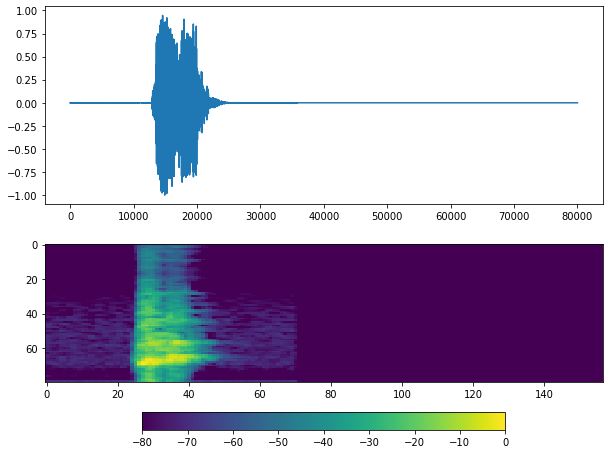

In [49]:
files = os.listdir(X_train_dir)
files.sort()
f = files[40]
y, sr = malaya_speech.load(X_train_dir+f)
plot(y,sr)
ipd.Audio(y, rate = sr)

# 取基頻

mel shape: (1, 80)


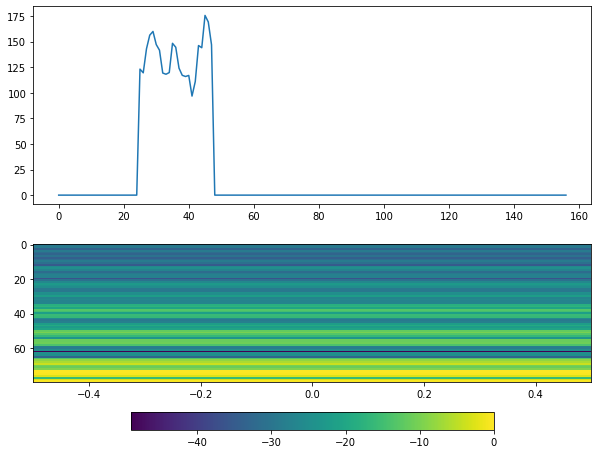

In [50]:
y_基頻 = rapt(y.astype('float32')*32767,sr,hopsize=512)
plot(y_基頻,sr)
ipd.Audio(y_基頻, rate = sr)

# 靜音部分消除

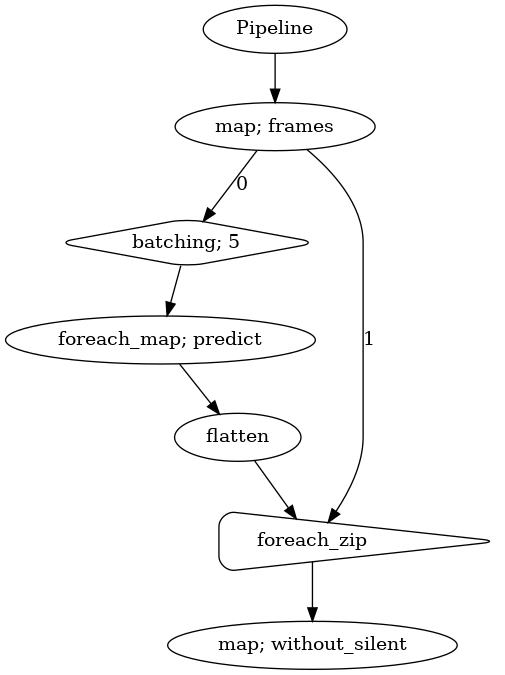

In [51]:
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent,
                                             threshold_to_stop = 0.05)

p.visualize()

In [52]:
def remove_silent(y,sr,time_length=80000):
    y =  p(y)['without_silent']
    if len(y) > time_length:
        y = y[0:0+time_length]
    else:
        y = np.pad(y, (0,time_length-len(y)))
    return y

mel shape: (157, 80)


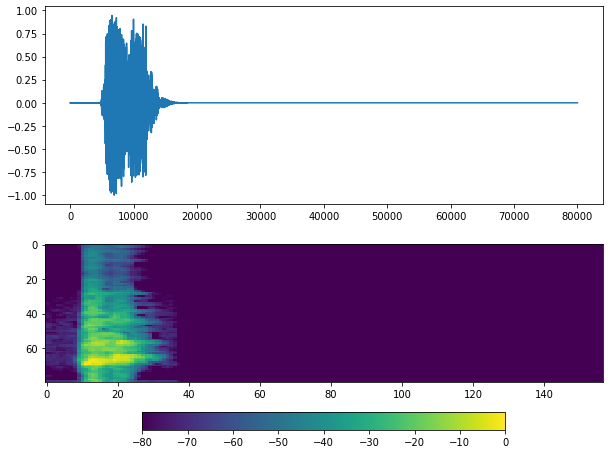

In [53]:
y_without_silent = remove_silent(y,sr)
plot(y_without_silent,sr)
ipd.Audio(y_without_silent, rate = sr)

# mel shape: (157, 80) #固定

# wav 2 features flow

In [54]:
def wav2featuresflow(y, sr):
    y_without_silent = remove_silent(y,sr)
    melspectrogram = np.rot90(norm_mel(y, sr))
    return melspectrogram

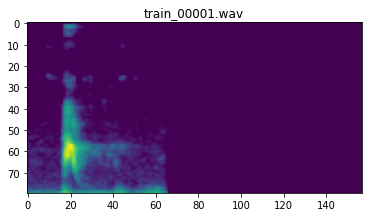

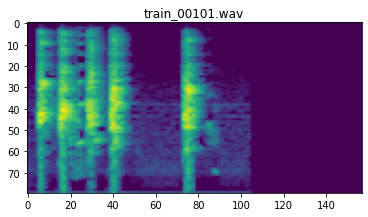

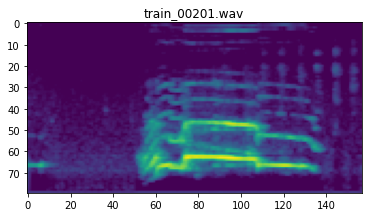

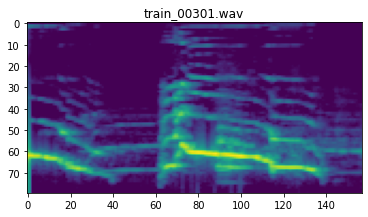

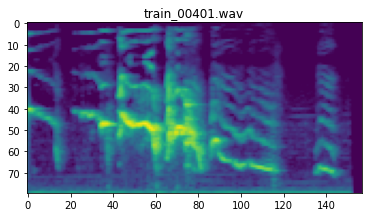

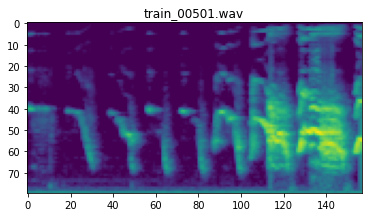

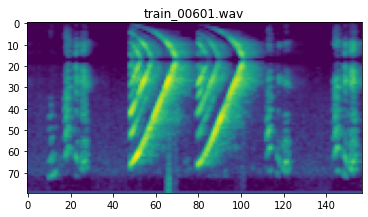

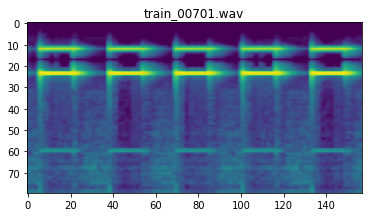

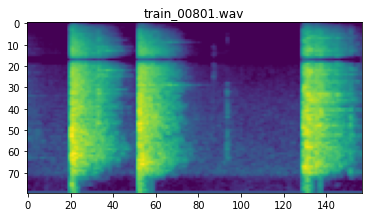

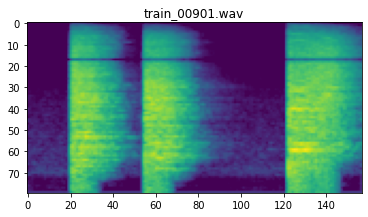

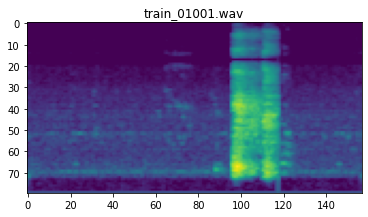

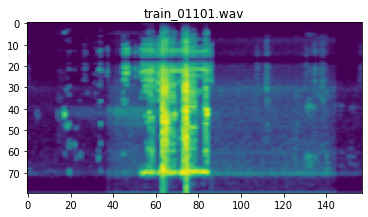

In [55]:
files = os.listdir(X_train_dir)
files.sort()
for f in files[::100]:
    y,sr = malaya_speech.load(X_train_dir+f)
    melspectrogram = wav2featuresflow(y,sr=16000)
    plt.imshow(melspectrogram)
    plt.title(f)
    plt.show()

# preprocessing 

In [146]:
def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X = torch.FloatTensor([])
    for f in tqdm(files):
        try:
            samples, sample_rate = malaya_speech.load(wav_dir+f)
            melspectrogram = wav2featuresflow(samples,sr=sample_rate)
            melspectrogram = melspectrogram.reshape(-1,80,157).copy()
            melspectrogram = torch.from_numpy(melspectrogram)
            X = torch.cat([X,torch.unsqueeze(melspectrogram,0)],dim=0)
            gc.collect()
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path)
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

# Load X

In [141]:
X_train = preprocessing_X(X_train_dir)
torch.save(X_train,'X_train_吳啟聖教的方法.pt')

 87%|████████▋ | 1046/1200 [38:25<04:40,  1.82s/it]

train_01046.wav


100%|██████████| 1200/1200 [44:08<00:00,  2.21s/it]


X shape: torch.Size([1199, 1, 80, 157])


In [142]:
X_train = torch.load('X_train_吳啟聖教的方法.pt')

In [ ]:
X_test = preprocessing_X(X_test_dir)
torch.save(X_test,'X_test_吳啟聖教的方法.pt')

In [ ]:
X_test = torch.load('X_test_吳啟聖教的方法.pt')

In [143]:
gc.collect()

11484

In [144]:
X_train.shape,X_test.shape

torch.Size([1199, 1, 80, 157])

# load Y

In [147]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Electrics'}

# look some sample

In [148]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

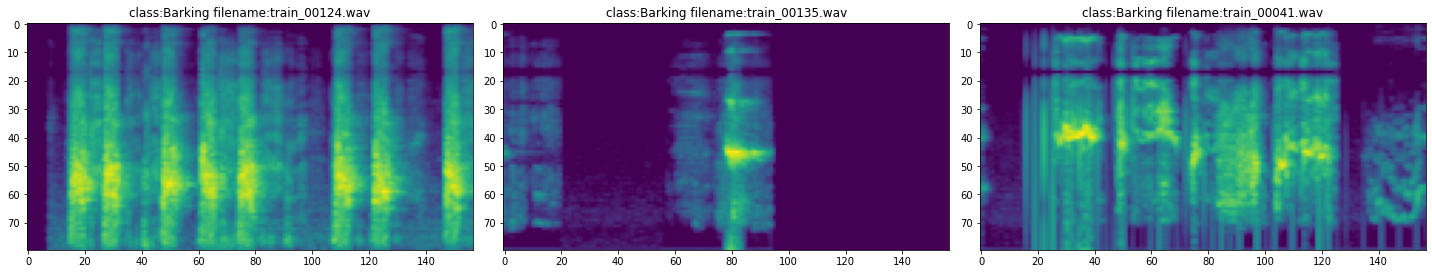

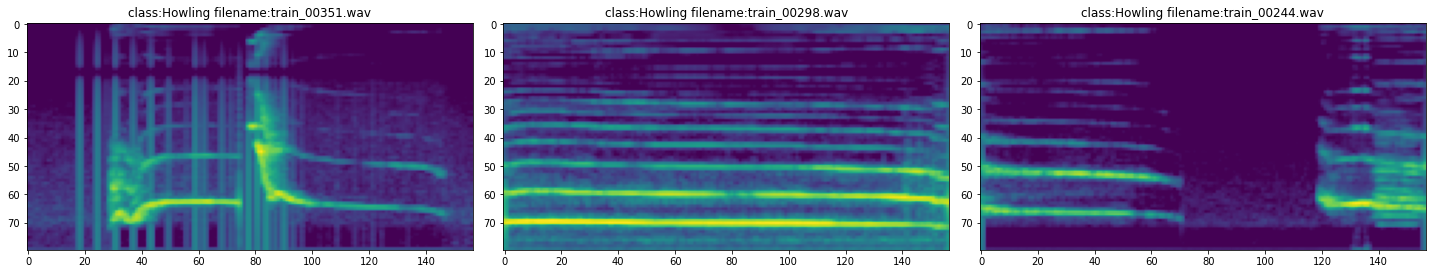

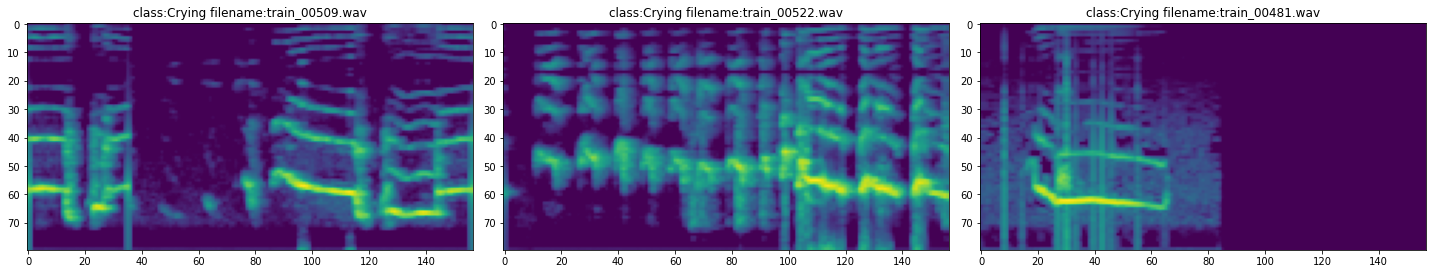

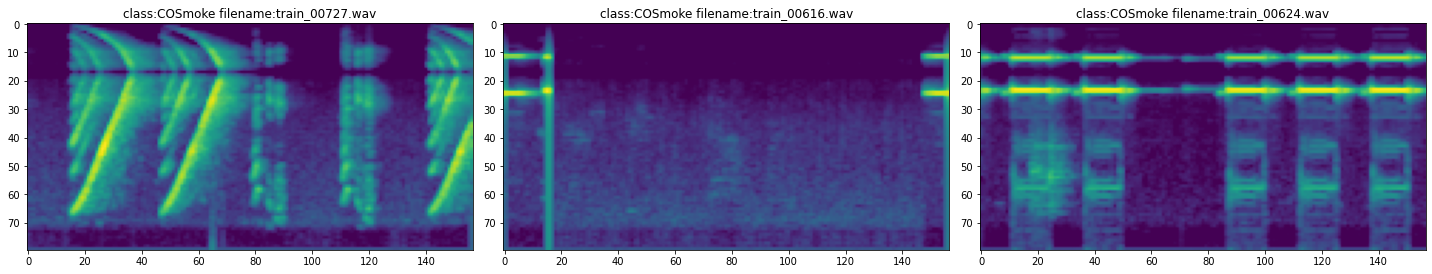

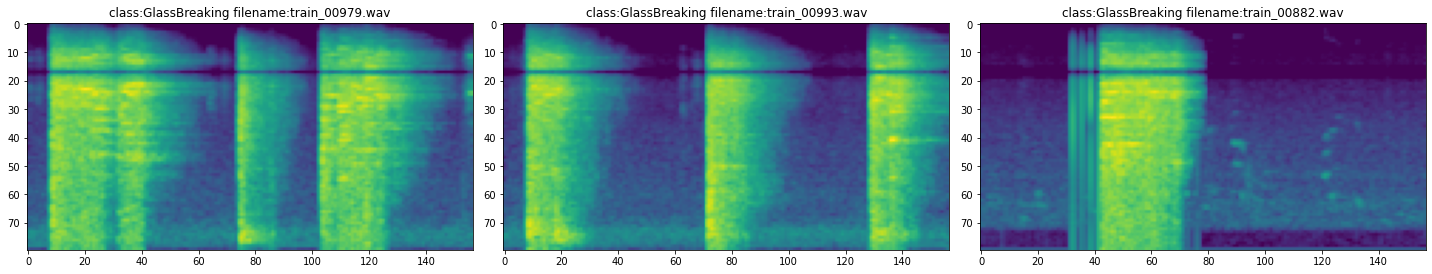

Other


<Figure size 1440x360 with 0 Axes>

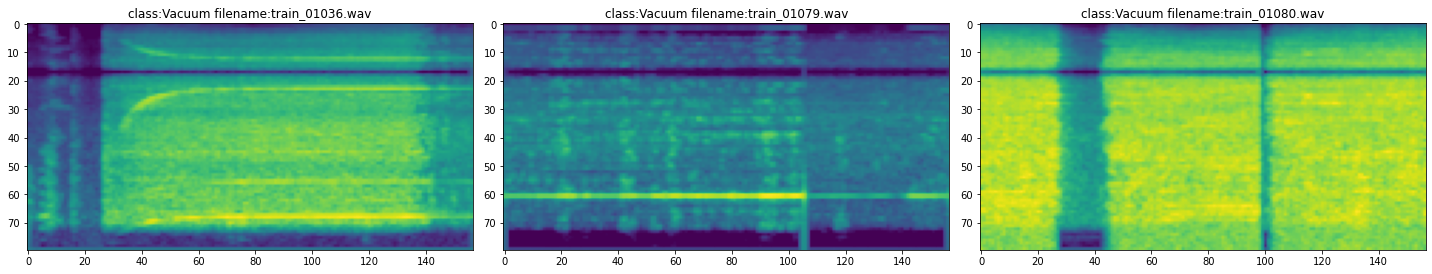

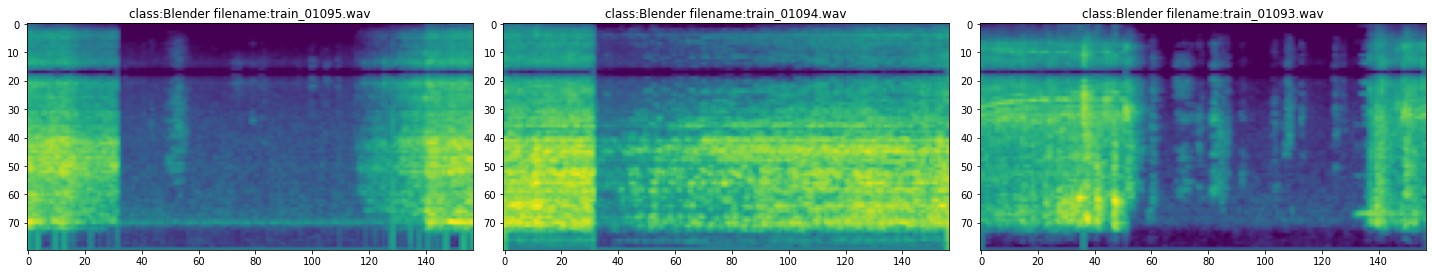

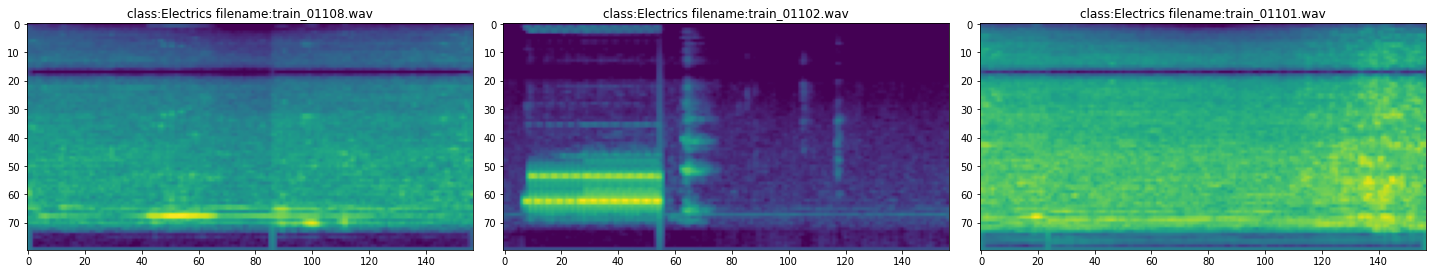

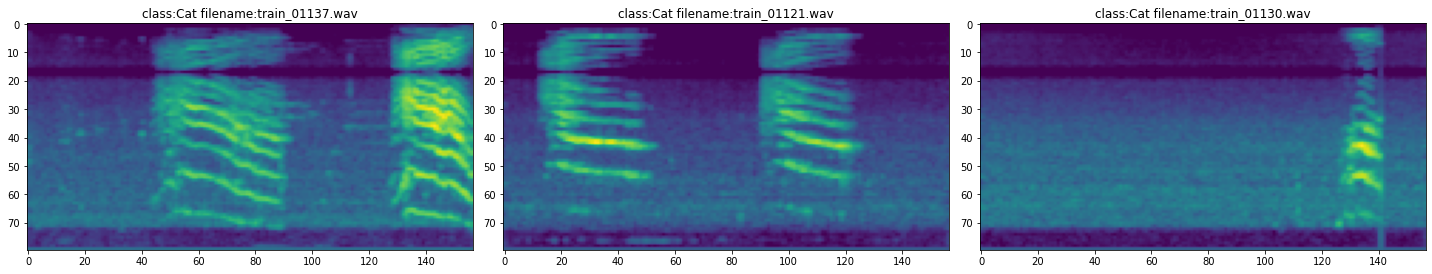

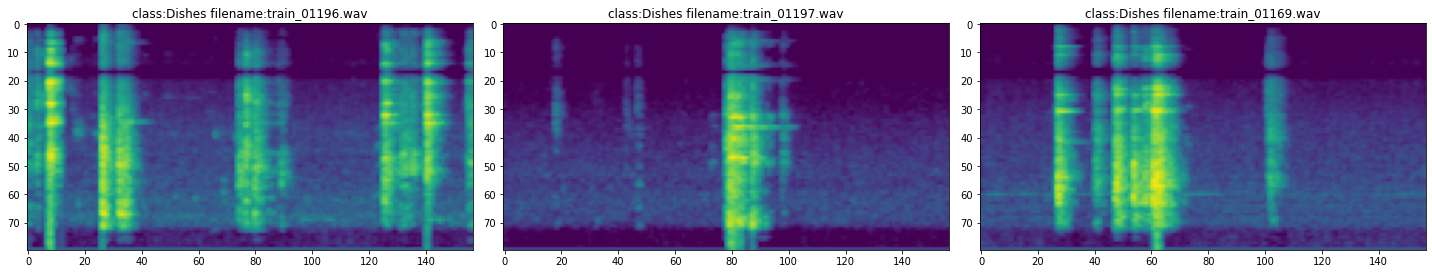

In [149]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [150]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42,stratify=Y_train)
print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([959, 1, 80, 157])
torch.Size([240, 1, 80, 157])
0    160
1    160
2    160
3    160
5    160
4    159
dtype: int64
0    40
1    40
2    40
3    40
4    40
5    40
dtype: int64


#  create pytorch dataloader and save

In [151]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=64,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=64,num_workers=4)

In [152]:
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([64, 1, 80, 157]) cpu
torch.Size([64, 6]) cpu


# define model

In [160]:
import torch.hub
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
print(model)

CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


# model forward test

In [161]:
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

torch.Size([64, 1, 80, 157]) torch.Size([64, 6])


torch.Size([64, 6])

# def train loop

In [162]:
def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

  0%|          | 0/100 [00:00<?, ?it/s]

CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

  1%|          | 1/100 [00:04<07:45,  4.70s/it]

epoch:0 train_loss:0.4698 valid_loss:0.3734 train_auc:0.0000 valid_auc:0.0000
epoch:1 train_loss:0.3371 valid_loss:0.3322 train_auc:0.0000 valid_auc:0.0000


  3%|▎         | 3/100 [00:12<06:52,  4.25s/it]

epoch:2 train_loss:0.2830 valid_loss:0.2777 train_auc:0.0000 valid_auc:0.0000


  4%|▍         | 4/100 [00:17<06:42,  4.19s/it]

epoch:3 train_loss:0.2423 valid_loss:0.2322 train_auc:0.0000 valid_auc:0.0000
epoch:4 train_loss:0.2180 valid_loss:0.2094 train_auc:0.0000 valid_auc:0.0000


  6%|▌         | 6/100 [00:25<06:32,  4.17s/it]

epoch:5 train_loss:0.1905 valid_loss:0.2230 train_auc:0.0000 valid_auc:0.0000


  7%|▋         | 7/100 [00:29<06:29,  4.19s/it]

epoch:6 train_loss:0.1681 valid_loss:0.1614 train_auc:0.0000 valid_auc:0.0000
epoch:7 train_loss:0.1483 valid_loss:0.1487 train_auc:0.0000 valid_auc:0.0000


  9%|▉         | 9/100 [00:39<06:50,  4.51s/it]

epoch:8 train_loss:0.1341 valid_loss:0.1591 train_auc:0.0000 valid_auc:0.0000


 10%|█         | 10/100 [00:43<06:45,  4.51s/it]

epoch:9 train_loss:0.1216 valid_loss:0.1425 train_auc:0.0000 valid_auc:0.0000


 11%|█         | 11/100 [00:47<06:34,  4.44s/it]

epoch:10 train_loss:0.1138 valid_loss:0.1608 train_auc:0.0000 valid_auc:0.0000


 12%|█▏        | 12/100 [00:52<06:26,  4.40s/it]

epoch:11 train_loss:0.1028 valid_loss:0.1544 train_auc:0.0000 valid_auc:0.0000


 13%|█▎        | 13/100 [00:56<06:20,  4.37s/it]

epoch:12 train_loss:0.0960 valid_loss:0.1398 train_auc:0.0000 valid_auc:0.0000
epoch:13 train_loss:0.0857 valid_loss:0.1349 train_auc:0.0000 valid_auc:0.0000


 15%|█▌        | 15/100 [01:05<06:04,  4.29s/it]

epoch:14 train_loss:0.0822 valid_loss:0.1621 train_auc:0.0000 valid_auc:0.0000


 16%|█▌        | 16/100 [01:09<05:56,  4.25s/it]

epoch:15 train_loss:0.0781 valid_loss:0.1512 train_auc:0.0000 valid_auc:0.0000


 17%|█▋        | 17/100 [01:13<05:52,  4.24s/it]

epoch:16 train_loss:0.0676 valid_loss:0.1563 train_auc:0.0000 valid_auc:0.0000
epoch:17 train_loss:0.0618 valid_loss:0.1337 train_auc:0.0000 valid_auc:0.0000


 19%|█▉        | 19/100 [01:21<05:39,  4.19s/it]

epoch:18 train_loss:0.0626 valid_loss:0.1401 train_auc:0.0000 valid_auc:0.0000


 20%|██        | 20/100 [01:25<05:33,  4.16s/it]

epoch:19 train_loss:0.0554 valid_loss:0.1816 train_auc:0.0000 valid_auc:0.0000


 21%|██        | 21/100 [01:29<05:27,  4.15s/it]

epoch:20 train_loss:0.0467 valid_loss:0.1603 train_auc:0.0000 valid_auc:0.0000


 22%|██▏       | 22/100 [01:34<05:23,  4.14s/it]

epoch:21 train_loss:0.0428 valid_loss:0.3456 train_auc:0.0000 valid_auc:0.0000


 23%|██▎       | 23/100 [01:38<05:18,  4.13s/it]

epoch:22 train_loss:0.0431 valid_loss:0.2992 train_auc:0.0000 valid_auc:0.0000
epoch:23 train_loss:0.0473 valid_loss:0.1314 train_auc:0.0000 valid_auc:0.0000


 25%|██▌       | 25/100 [01:46<05:09,  4.13s/it]

epoch:24 train_loss:0.0442 valid_loss:0.3434 train_auc:0.0000 valid_auc:0.0000


 26%|██▌       | 26/100 [01:50<05:05,  4.13s/it]

epoch:25 train_loss:0.0441 valid_loss:0.2075 train_auc:0.0000 valid_auc:0.0000


 27%|██▋       | 27/100 [01:54<05:00,  4.12s/it]

epoch:26 train_loss:0.0431 valid_loss:0.2669 train_auc:0.0000 valid_auc:0.0000


 28%|██▊       | 28/100 [01:58<04:54,  4.09s/it]

epoch:27 train_loss:0.0356 valid_loss:0.2386 train_auc:0.0000 valid_auc:0.0000


 29%|██▉       | 29/100 [02:02<04:51,  4.10s/it]

epoch:28 train_loss:0.0284 valid_loss:0.1926 train_auc:0.0000 valid_auc:0.0000


 30%|███       | 30/100 [02:06<04:47,  4.10s/it]

epoch:29 train_loss:0.0248 valid_loss:0.1409 train_auc:0.0000 valid_auc:0.0000


 31%|███       | 31/100 [02:11<04:43,  4.10s/it]

epoch:30 train_loss:0.0260 valid_loss:0.2116 train_auc:0.0000 valid_auc:0.0000


 32%|███▏      | 32/100 [02:15<04:37,  4.07s/it]

epoch:31 train_loss:0.0178 valid_loss:0.1893 train_auc:0.0000 valid_auc:0.0000


 33%|███▎      | 33/100 [02:19<04:35,  4.11s/it]

epoch:32 train_loss:0.0160 valid_loss:0.2614 train_auc:0.0000 valid_auc:0.0000


 34%|███▍      | 34/100 [02:23<04:33,  4.14s/it]

epoch:33 train_loss:0.0149 valid_loss:0.1346 train_auc:0.0000 valid_auc:0.0000


 35%|███▌      | 35/100 [02:27<04:27,  4.12s/it]

epoch:34 train_loss:0.0136 valid_loss:0.5450 train_auc:0.0000 valid_auc:0.0000


 36%|███▌      | 36/100 [02:31<04:20,  4.08s/it]

epoch:35 train_loss:0.0181 valid_loss:0.2104 train_auc:0.0000 valid_auc:0.0000


 37%|███▋      | 37/100 [02:35<04:17,  4.09s/it]

epoch:36 train_loss:0.0164 valid_loss:0.1629 train_auc:0.0000 valid_auc:0.0000


 38%|███▊      | 38/100 [02:39<04:12,  4.07s/it]

epoch:37 train_loss:0.0116 valid_loss:0.2598 train_auc:0.0000 valid_auc:0.0000


 39%|███▉      | 39/100 [02:44<04:31,  4.44s/it]

epoch:38 train_loss:0.0111 valid_loss:0.1487 train_auc:0.0000 valid_auc:0.0000
epoch:39 train_loss:0.0108 valid_loss:0.1311 train_auc:0.0000 valid_auc:0.0000


 41%|████      | 41/100 [02:53<04:20,  4.42s/it]

epoch:40 train_loss:0.0059 valid_loss:0.1683 train_auc:0.0000 valid_auc:0.0000


 42%|████▏     | 42/100 [02:57<04:11,  4.34s/it]

epoch:41 train_loss:0.0038 valid_loss:0.1450 train_auc:0.0000 valid_auc:0.0000


 43%|████▎     | 43/100 [03:02<04:04,  4.28s/it]

epoch:42 train_loss:0.0026 valid_loss:0.1588 train_auc:0.0000 valid_auc:0.0000


 44%|████▍     | 44/100 [03:06<03:57,  4.24s/it]

epoch:43 train_loss:0.0021 valid_loss:0.1620 train_auc:0.0000 valid_auc:0.0000


 45%|████▌     | 45/100 [03:10<03:52,  4.22s/it]

epoch:44 train_loss:0.0018 valid_loss:0.1638 train_auc:0.0000 valid_auc:0.0000


 46%|████▌     | 46/100 [03:14<03:47,  4.21s/it]

epoch:45 train_loss:0.0016 valid_loss:0.1656 train_auc:0.0000 valid_auc:0.0000


 47%|████▋     | 47/100 [03:18<03:43,  4.21s/it]

epoch:46 train_loss:0.0015 valid_loss:0.1669 train_auc:0.0000 valid_auc:0.0000


 48%|████▊     | 48/100 [03:22<03:37,  4.18s/it]

epoch:47 train_loss:0.0014 valid_loss:0.1690 train_auc:0.0000 valid_auc:0.0000


 49%|████▉     | 49/100 [03:27<03:32,  4.16s/it]

epoch:48 train_loss:0.0013 valid_loss:0.1707 train_auc:0.0000 valid_auc:0.0000


 50%|█████     | 50/100 [03:31<03:29,  4.19s/it]

epoch:49 train_loss:0.0012 valid_loss:0.1720 train_auc:0.0000 valid_auc:0.0000


 51%|█████     | 51/100 [03:35<03:24,  4.17s/it]

epoch:50 train_loss:0.0012 valid_loss:0.1733 train_auc:0.0000 valid_auc:0.0000


 52%|█████▏    | 52/100 [03:39<03:19,  4.16s/it]

epoch:51 train_loss:0.0011 valid_loss:0.1746 train_auc:0.0000 valid_auc:0.0000
epoch:52 train_loss:0.0011 valid_loss:0.1758 train_auc:0.0000 valid_auc:0.0000


 54%|█████▍    | 54/100 [03:47<03:11,  4.16s/it]

epoch:53 train_loss:0.0010 valid_loss:0.1770 train_auc:0.0000 valid_auc:0.0000


 55%|█████▌    | 55/100 [03:52<03:07,  4.16s/it]

epoch:54 train_loss:0.0010 valid_loss:0.1782 train_auc:0.0000 valid_auc:0.0000


 56%|█████▌    | 56/100 [03:56<03:04,  4.20s/it]

epoch:55 train_loss:0.0009 valid_loss:0.1795 train_auc:0.0000 valid_auc:0.0000


 57%|█████▋    | 57/100 [04:00<02:59,  4.18s/it]

epoch:56 train_loss:0.0009 valid_loss:0.1807 train_auc:0.0000 valid_auc:0.0000


 58%|█████▊    | 58/100 [04:04<02:54,  4.15s/it]

epoch:57 train_loss:0.0009 valid_loss:0.1818 train_auc:0.0000 valid_auc:0.0000


 59%|█████▉    | 59/100 [04:08<02:49,  4.14s/it]

epoch:58 train_loss:0.0008 valid_loss:0.1827 train_auc:0.0000 valid_auc:0.0000


 60%|██████    | 60/100 [04:12<02:46,  4.15s/it]

epoch:59 train_loss:0.0008 valid_loss:0.1837 train_auc:0.0000 valid_auc:0.0000


 61%|██████    | 61/100 [04:17<02:42,  4.18s/it]

epoch:60 train_loss:0.0008 valid_loss:0.1848 train_auc:0.0000 valid_auc:0.0000


 62%|██████▏   | 62/100 [04:21<02:38,  4.18s/it]

epoch:61 train_loss:0.0007 valid_loss:0.1858 train_auc:0.0000 valid_auc:0.0000


 63%|██████▎   | 63/100 [04:25<02:34,  4.18s/it]

epoch:62 train_loss:0.0007 valid_loss:0.1868 train_auc:0.0000 valid_auc:0.0000


 64%|██████▍   | 64/100 [04:29<02:29,  4.15s/it]

epoch:63 train_loss:0.0007 valid_loss:0.1879 train_auc:0.0000 valid_auc:0.0000


 65%|██████▌   | 65/100 [04:33<02:25,  4.14s/it]

epoch:64 train_loss:0.0007 valid_loss:0.1888 train_auc:0.0000 valid_auc:0.0000


 66%|██████▌   | 66/100 [04:37<02:20,  4.13s/it]

epoch:65 train_loss:0.0006 valid_loss:0.1898 train_auc:0.0000 valid_auc:0.0000


 67%|██████▋   | 67/100 [04:41<02:17,  4.16s/it]

epoch:66 train_loss:0.0006 valid_loss:0.1908 train_auc:0.0000 valid_auc:0.0000


 68%|██████▊   | 68/100 [04:47<02:24,  4.52s/it]

epoch:67 train_loss:0.0006 valid_loss:0.1917 train_auc:0.0000 valid_auc:0.0000


 69%|██████▉   | 69/100 [04:51<02:18,  4.47s/it]

epoch:68 train_loss:0.0006 valid_loss:0.1926 train_auc:0.0000 valid_auc:0.0000


 70%|███████   | 70/100 [04:55<02:11,  4.37s/it]

epoch:69 train_loss:0.0006 valid_loss:0.1935 train_auc:0.0000 valid_auc:0.0000


 71%|███████   | 71/100 [05:00<02:06,  4.38s/it]

epoch:70 train_loss:0.0005 valid_loss:0.1944 train_auc:0.0000 valid_auc:0.0000


 72%|███████▏  | 72/100 [05:04<02:01,  4.33s/it]

epoch:71 train_loss:0.0005 valid_loss:0.1952 train_auc:0.0000 valid_auc:0.0000


 73%|███████▎  | 73/100 [05:08<01:55,  4.28s/it]

epoch:72 train_loss:0.0005 valid_loss:0.1961 train_auc:0.0000 valid_auc:0.0000


 74%|███████▍  | 74/100 [05:12<01:49,  4.21s/it]

epoch:73 train_loss:0.0005 valid_loss:0.1970 train_auc:0.0000 valid_auc:0.0000


 75%|███████▌  | 75/100 [05:16<01:44,  4.17s/it]

epoch:74 train_loss:0.0005 valid_loss:0.1980 train_auc:0.0000 valid_auc:0.0000


 76%|███████▌  | 76/100 [05:21<01:41,  4.22s/it]

epoch:75 train_loss:0.0005 valid_loss:0.1989 train_auc:0.0000 valid_auc:0.0000


 77%|███████▋  | 77/100 [05:25<01:36,  4.21s/it]

epoch:76 train_loss:0.0005 valid_loss:0.1995 train_auc:0.0000 valid_auc:0.0000


 78%|███████▊  | 78/100 [05:29<01:32,  4.19s/it]

epoch:77 train_loss:0.0005 valid_loss:0.2004 train_auc:0.0000 valid_auc:0.0000
epoch:78 train_loss:0.0004 valid_loss:0.2012 train_auc:0.0000 valid_auc:0.0000


 80%|████████  | 80/100 [05:37<01:23,  4.17s/it]

epoch:79 train_loss:0.0004 valid_loss:0.2020 train_auc:0.0000 valid_auc:0.0000


 81%|████████  | 81/100 [05:41<01:19,  4.16s/it]

epoch:80 train_loss:0.0004 valid_loss:0.2027 train_auc:0.0000 valid_auc:0.0000


 82%|████████▏ | 82/100 [05:46<01:15,  4.20s/it]

epoch:81 train_loss:0.0004 valid_loss:0.2035 train_auc:0.0000 valid_auc:0.0000


 83%|████████▎ | 83/100 [05:50<01:11,  4.20s/it]

epoch:82 train_loss:0.0004 valid_loss:0.2042 train_auc:0.0000 valid_auc:0.0000


 84%|████████▍ | 84/100 [05:54<01:07,  4.20s/it]

epoch:83 train_loss:0.0004 valid_loss:0.2049 train_auc:0.0000 valid_auc:0.0000


 85%|████████▌ | 85/100 [05:58<01:03,  4.22s/it]

epoch:84 train_loss:0.0004 valid_loss:0.2057 train_auc:0.0000 valid_auc:0.0000


 86%|████████▌ | 86/100 [06:02<00:58,  4.18s/it]

epoch:85 train_loss:0.0004 valid_loss:0.2064 train_auc:0.0000 valid_auc:0.0000


 87%|████████▋ | 87/100 [06:06<00:53,  4.15s/it]

epoch:86 train_loss:0.0004 valid_loss:0.2072 train_auc:0.0000 valid_auc:0.0000


 88%|████████▊ | 88/100 [06:11<00:49,  4.15s/it]

epoch:87 train_loss:0.0004 valid_loss:0.2079 train_auc:0.0000 valid_auc:0.0000


 89%|████████▉ | 89/100 [06:15<00:46,  4.19s/it]

epoch:88 train_loss:0.0003 valid_loss:0.2087 train_auc:0.0000 valid_auc:0.0000


 90%|█████████ | 90/100 [06:19<00:41,  4.18s/it]

epoch:89 train_loss:0.0003 valid_loss:0.2093 train_auc:0.0000 valid_auc:0.0000


 91%|█████████ | 91/100 [06:23<00:37,  4.16s/it]

epoch:90 train_loss:0.0003 valid_loss:0.2102 train_auc:0.0000 valid_auc:0.0000


 92%|█████████▏| 92/100 [06:27<00:33,  4.18s/it]

epoch:91 train_loss:0.0003 valid_loss:0.2108 train_auc:0.0000 valid_auc:0.0000


 93%|█████████▎| 93/100 [06:31<00:28,  4.14s/it]

epoch:92 train_loss:0.0003 valid_loss:0.2114 train_auc:0.0000 valid_auc:0.0000


 94%|█████████▍| 94/100 [06:36<00:24,  4.14s/it]

epoch:93 train_loss:0.0003 valid_loss:0.2122 train_auc:0.0000 valid_auc:0.0000


 95%|█████████▌| 95/100 [06:40<00:20,  4.13s/it]

epoch:94 train_loss:0.0003 valid_loss:0.2127 train_auc:0.0000 valid_auc:0.0000


 96%|█████████▌| 96/100 [06:44<00:16,  4.12s/it]

epoch:95 train_loss:0.0003 valid_loss:0.2134 train_auc:0.0000 valid_auc:0.0000


 97%|█████████▋| 97/100 [06:49<00:13,  4.45s/it]

epoch:96 train_loss:0.0003 valid_loss:0.2140 train_auc:0.0000 valid_auc:0.0000
epoch:97 train_loss:0.0003 valid_loss:0.2147 train_auc:0.0000 valid_auc:0.0000


 99%|█████████▉| 99/100 [06:58<00:04,  4.40s/it]

epoch:98 train_loss:0.0003 valid_loss:0.2154 train_auc:0.0000 valid_auc:0.0000


100%|██████████| 100/100 [07:02<00:00,  4.22s/it]

epoch:99 train_loss:0.0003 valid_loss:0.2160 train_auc:0.0000 valid_auc:0.0000


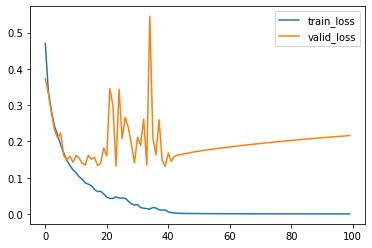

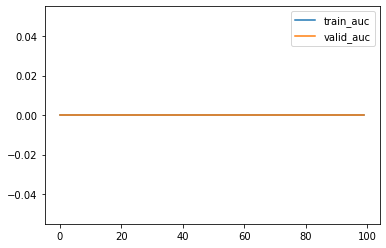

AttributeError: Can't pickle local object 'CifarSEBasicBlock.__init__.<locals>.<lambda>'

In [163]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = 'cuda:0'
model = model.to(device)
print(model)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=100,log_interval=1,device=device)

# model infernce test

In [164]:
from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

In [165]:
cm,acc = plot_confusion_matrix(model,train_iter)
print(acc)
cm

100%|██████████| 15/15 [00:01<00:00,  9.14it/s]

0.9958289885297185


Barking  Howling  Crying  COSmoke  GlassBreaking  Electrics
0      159        0       1        0              0          0
1        1      159       0        0              0          0
2        0        0     158        0              0          0
3        0        0       1      160              0          0
4        0        0       0        0            159          0
5        0        1       0        0              0        160

In [166]:
cm,acc = plot_confusion_matrix(model,vaild_iter)
print(acc)
cm

100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

0.8791666666666667


Barking  Howling  Crying  COSmoke  GlassBreaking  Electrics
0       34        0       1        1              0          1
1        1       34       8        0              0          1
2        2        2      29        1              0          0
3        1        0       0       38              0          1
4        0        0       0        0             39          0
5        2        4       2        0              1         37

# submit

In [168]:
print(X_test.shape[0])

NameError: name 'X_test' is not defined

In [ ]:
sample_submit = pd.read_csv('sample_submission.csv')
model = model.to('cuda:0')
model.eval()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

In [ ]:
# save
sample_submit.to_csv('submit_senet20_wu.csv',index=False)
print('done')